# 使用 MMDetection 训练检测模型 


## 进入 mmdetection 主目录

In [1]:
import os
os.chdir('mmdetection')

## 下载KITTI目标检测数据集

In [2]:
# 下载压缩包
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip

--2022-08-29 15:36:24--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 6918271 (6.6M) [application/zip]
正在保存至: “kitti_tiny.zip”

kitti_tiny.zip      100%[===================>]   6.60M  --.-KB/s    用时 0.07s   

2022-08-29 15:36:24 (96.9 MB/s) - 已保存 “kitti_tiny.zip” [6918271/6918271])



In [3]:
# 解压
!unzip kitti_tiny.zip > /dev/null

In [4]:
# 查看 kitti_tiny 的目录结构
!sudo snap install tree

tree 1.8.0+pkg-3fd6 已从 林博仁(Buo-ren, Lin) (brlin) 安装      |.0ns


In [5]:
!tree kitti_tiny

locales-launch: Data of zh_CN locale not found, generating, please wait...
kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpeg
│   │   ├── 000005.jpeg
│   │   ├── 000006.jpeg
│   │   ├── 000007.jpeg
│   │   ├── 000008.jpeg
│   │   ├── 000009.jpeg
│   │   ├── 000010.jpeg
│   │   ├── 000011.jpeg
│   │   ├── 000012.jpeg
│   │   ├── 000013.jpeg
│   │   ├── 000014.jpeg
│   │   ├── 000015.jpeg
│   │   ├── 000016.jpeg
│   │   ├── 000017.jpeg
│   │   ├── 000018.jpeg
│   │   ├── 000019.jpeg
│   │   ├── 000020.jpeg
│   │   ├── 000021.jpeg
│   │   ├── 000022.jpeg
│   │   ├── 000023.jpeg
│   │   ├── 000024.jpeg
│   │   ├── 000025.jpeg
│   │   ├── 000026.jpeg
│   │   ├── 000027.jpeg
│   │   ├── 000028.jpeg
│   │   ├── 000029.jpeg
│   │   ├── 000030.jpeg
│   │   ├── 000031.jpeg
│   │   ├── 000032.jpeg
│   │   ├── 000033.jpeg
│   │   ├── 000034.jpeg
│   │   ├── 000035.jpeg
│   │   ├── 000036.jp

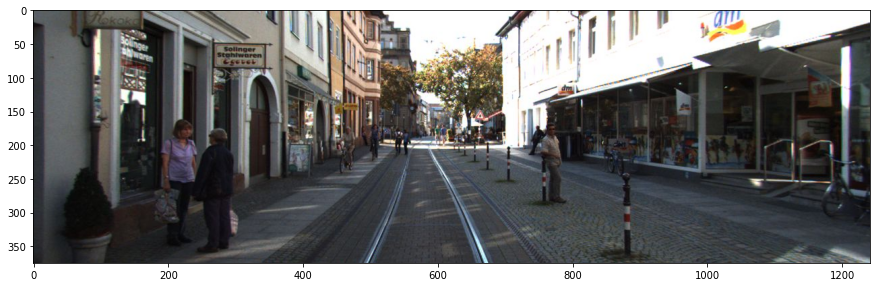

In [6]:
# 简单查看数据集的图片
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [7]:
# 查看单张图的标注信息
!cat kitti_tiny/training/label_2/000073.txt

Pedestrian 0.00 0 -2.62 237.23 173.70 312.33 365.33 1.58 0.66 0.53 -2.99 1.60 6.32 -3.05
Pedestrian 0.00 1 0.80 189.46 158.23 256.19 356.44 1.70 0.61 0.51 -3.62 1.58 6.54 0.31
Pedestrian 0.00 0 0.45 752.95 164.08 791.19 288.78 1.75 0.63 0.51 2.28 1.63 10.51 0.65
Cyclist 0.00 0 1.78 444.66 170.48 485.70 241.86 1.64 0.57 2.00 -3.55 1.60 17.61 1.58
Cyclist 0.00 0 1.65 494.34 168.08 517.01 223.73 1.80 0.60 1.85 -3.54 1.66 24.31 1.51
Pedestrian 0.00 0 -2.07 546.73 177.07 560.52 214.88 1.53 0.61 0.73 -2.41 1.71 29.83 -2.15
Pedestrian 0.00 0 -2.02 535.68 174.41 549.63 214.38 1.61 0.54 0.87 -2.86 1.68 29.55 -2.12
DontCare -1 -1 -10 596.02 166.69 615.85 203.19 -1 -1 -1 -1000 -1000 -1000 -10


## 在自定义数据集上训练目标检测模型

MMDetection 提供的与训练模型大多基于COCO数据集，及其中的80类物体。
如果我们希望模型检测到其他类新的物体，就需要用自定义的数据集训练检测模型。
MMDetection支持使用自定义模型训练检测模型。

训练新模型通常有三个步骤:
1. 支持新数据集
2. 修改配置文件
3. 训练模型

而MMDetection中有三种方法来支持新数据集: 
1. 将数据集整理为COCO格式
2. 将数据集转换为中间格式
3. 直接实现新数据集的支持


其他方法以及进阶用法可以参考[文档](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#)。

## 方法一：MS COCO标注格式的数据集

## 方法二：将数据集转换为中间格式

这里我们将基于数据集[KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d)，通过方法二来完成本节教程。我们选取3D物体检测数据集中的前75张图像以及标注信息来做训练，并将图像PNG转换为80%质量的JPEG来减少数据集大小。


根据KITTI数据集文档，标注的第一列指物体的类别，第五列到第八列指的是边界框的左上右下坐标，这些就是我们需要转换的信息。

### 数据集中间格式定义

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray, float32> (n, 4),
            'labels': <np.ndarray, int64> (n, ),
            'bboxes_ignore': <np.ndarray, float32> (k, 4),
            'labels_ignore': <np.ndarray, int64> (k, ) (optional field)
        }
    },
    ...
]
```
我们需要根据上述中间类型来编写转换函数。

### 将标注文件转换为中间格式

In [8]:
import os.path as osp
import numpy as np
import mmcv

def convert_kitti_to_middle(ann_file, out_file, img_prefix):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')
    # 类别反查表
    cat2label = {k: i for i, k in enumerate(CLASSES)}
    # 图像列表
    image_list = mmcv.list_from_file(ann_file)

    # 所有图像和标注的信息存储在一个列表中
    data_infos = []
    # convert annotations to middle format
    for image_id in image_list:
        filename = f'{img_prefix}/{image_id}.jpeg'
        image = mmcv.imread(filename)
        height, width = image.shape[:2]

        # 单张图像的信息存储在字典中
        data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)

        # 读取标注信息，并处理
        label_prefix = img_prefix.replace('image_2', 'label_2')
        lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))

        content = [line.strip().split(' ') for line in lines]
        bbox_names = [x[0] for x in content]
        bboxes = [[float(info) for info in x[4:8]] for x in content]

        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        gt_labels_ignore = []

        # filter 'DontCare'
        for bbox_name, bbox in zip(bbox_names, bboxes):
            if bbox_name in cat2label:
                gt_labels.append(cat2label[bbox_name])
                gt_bboxes.append(bbox)
            else:
                gt_labels_ignore.append(-1)
                gt_bboxes_ignore.append(bbox)

        # 将标注信息（坐标和标签）转换为nparray
        data_anno = dict(
            bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
            labels=np.array(gt_labels, dtype=np.long),
            bboxes_ignore=np.array(gt_bboxes_ignore,
                                    dtype=np.float32).reshape(-1, 4),
            labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

        data_info.update(ann=data_anno)
        # 所有图像和标注的信息存储在一个列表中
        data_infos.append(data_info)
    mmcv.dump(data_infos, out_file)

convert_kitti_to_middle('kitti_tiny/train.txt', 'kitti_tiny/train_middle.pkl', 'kitti_tiny/training/image_2')
convert_kitti_to_middle('kitti_tiny/val.txt', 'kitti_tiny/val_middle.pkl', 'kitti_tiny/training/image_2')

/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you

### 修改 config 配置文件

In [9]:
from mmcv import Config
from mmdet.apis import set_random_seed

# 获取基本配置文件参数
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

# 修改数据集类型以及文件路径
cfg.dataset_type = 'CustomDataset'
cfg.data_root = 'kitti_tiny/'
cfg.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.test.type = 'CustomDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train_middle.pkl'
cfg.data.test.img_prefix = 'training/image_2'
cfg.data.test.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.train.type = 'CustomDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train_middle.pkl'
cfg.data.train.img_prefix = 'training/image_2'
cfg.data.train.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.val.type = 'CustomDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val_middle.pkl'
cfg.data.val.img_prefix = 'training/image_2'
cfg.data.val.classes = ('Car', 'Pedestrian', 'Cyclist')

# 修改bbox_head中的类别数
cfg.model.roi_head.bbox_head.num_classes = 3
# 使用预训练好的faster rcnn模型用于finetuning
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth'
# 设置工作目录用于存放log和临时文件
cfg.work_dir = './work_dir_custom'

# 原本的学习率是在8卡基础上训练设置的，现在单卡需要除以8
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# 由于是自定义数据集，需要修改评价方法
cfg.evaluation.metric = 'mAP'
# 设置evaluation间隔减少运行时间
cfg.evaluation.interval = 12
# 设置存档点间隔减少存储空间的消耗
cfg.checkpoint_config.interval = 12

# 固定随机种子使得结果可复现
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device = 'cuda'

# 打印所有的配置参数
# print(f'Config:\n{cfg.pretty_text}')

mmcv.mkdir_or_exist(F'{cfg.work_dir}')
cfg.dump(F'{cfg.work_dir}/customformat.py')

### 训练模型

根据 config 配置文件构建数据集、目标检测模型，并完成训练。

In [14]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建检测模型
model = build_detector(cfg.model)

# 添加类别文字属性提高可视化效果
model.CLASSES = datasets[0].CLASSES

# 创建工作目录并训练模型
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [15]:
# 训练模型
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-08-29 15:40:28,653 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-08-29 15:40:28,659 - mmdet - INFO - load checkpoint from local path: checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth
2022-08-29 15:40:28,793 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current m

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 22.4 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-08-29 15:41:45,598 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 139  | 0.887  | 0.811 |
| Pedestrian | 13  | 67   | 0.846  | 0.775 |
| Cyclist    | 7   | 42   | 0.429  | 0.071 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.552 |
+------------+-----+------+--------+-------+
2022-08-29 15:41:45,601 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5520, mAP: 0.5524


### 测试集上评估模型

训练完模型后，需要对模型进行评价分析，这里可以用mmdet提供的test.py来直接运行。更多评价方法可以查看[这里](https://mmdetection.readthedocs.io/en/latest/1_exist_data_model.html)

In [16]:
!python tools/test.py work_dir_custom/customformat.py work_dir_custom/latest.pth --eval mAP

/home/featurize/work/【MMDetection】/mmdetection/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/home/featurize/work/【MMDetection】/mmdetection/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
load checkpoint from local path: work_dir_custom/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 50/50, 24.7 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------

+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap

### 预测新图像

/home/featurize/work/【MMDetection】/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


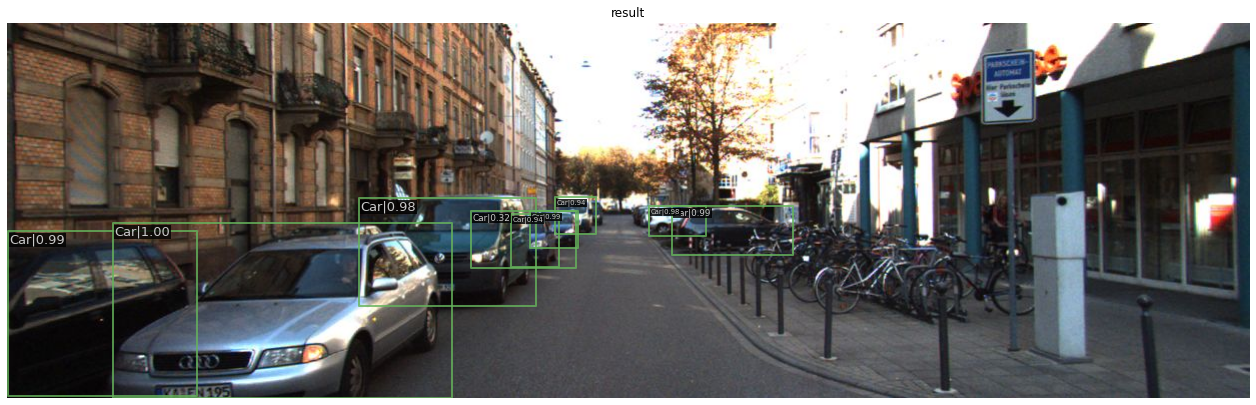

In [17]:
import mmcv
from mmdet.apis import inference_detector, show_result_pyplot

img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

## 方法三：直接实现新数据集的支持

方法一、二是离线方法，需要将数据转换好存到磁盘上，再进行训练。
MMDetection还支持一种在线的方法，可以直接从原始数据集文件读取数据，在线完成转换（至MMDetection的中间格式），并发送给模型用于训练，过程中需不需要存储额外数据到硬盘上。


这里我们将同样基于数据集[KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d)，通过方法三完成训练。


在`mmdet/datasets`新建`KittiTinyDataset.py`文件，填充内容如下：

并在`mmdet/datasets/__init__.py`中，增加`from .KittiTinyDataset import KittiTinyDataset`

In [18]:
# mmdet/datasets/KittiTinyDataset.py

import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# 注册表的装饰器，这样builder根据配置文件构建时就可以识别KittiTinyDataset数据集类型
# 继承CustomDataset并重载load_annotations函数
@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### 修改 config 配置文件

In [24]:
from mmcv import Config
from mmdet.apis import set_random_seed

# 获取基本配置文件参数
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

# 修改数据集类型以及文件路径
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# 修改bbox_head中的类别数
cfg.model.roi_head.bbox_head.num_classes = 3
# 使用预训练好的faster rcnn模型用于finetuning
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth'
# 设置工作目录用于存放log和临时文件
cfg.work_dir = 'work_dirs/C'

# 原本的学习率是在8卡基础上训练设置的，现在单卡需要除以8
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# 由于是自定义数据集，需要修改评价方法
cfg.evaluation.metric = 'mAP'
# 设置evaluation间隔减少运行时间
cfg.evaluation.interval = 12
# 设置存档点间隔减少存储空间的消耗
cfg.checkpoint_config.interval = 12

# 固定随机种子使得结果可复现
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device = 'cuda'

# 打印所有的配置参数
# print(f'Config:\n{cfg.pretty_text}')

mmcv.mkdir_or_exist(F'{cfg.work_dir}')
cfg.dump(F'{cfg.work_dir}/customformat.py')

### 训练模型

In [25]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建检测模型
model = build_detector(cfg.model)
# 添加类别文字属性提高可视化效果
model.CLASSES = datasets[0].CLASSES

# 创建工作目录并训练模型
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you

In [26]:
# 训练模型
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-08-29 15:46:42,851 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 22.3 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-08-29 15:48:00,223 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 152  | 0.968  | 0.850 |
| Pedestrian | 13  | 53   | 0.846  | 0.782 |
| Cyclist    | 7   | 53   | 0.571  | 0.079 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.571 |
+------------+-----+------+--------+-------+
2022-08-29 15:48:00,226 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5710, mAP: 0.5706


### 测试集上评估模型

训练完模型后，需要对模型进行评价分析，这里可以用mmdet提供的test.py来直接运行。更多评价方法可以查看[这里](https://mmdetection.readthedocs.io/en/latest/1_exist_data_model.html)

In [33]:
!python tools/test.py work_dirs/C/customformat.py work_dirs/C/latest.pth --eval mAP

/home/featurize/work/【MMDetection】/mmdetection/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/home/featurize/work/【MMDetection】/mmdetection/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
load checkpoint from local path: work_dirs/C/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 50/50, 25.4 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------

+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    

### 预测新图像

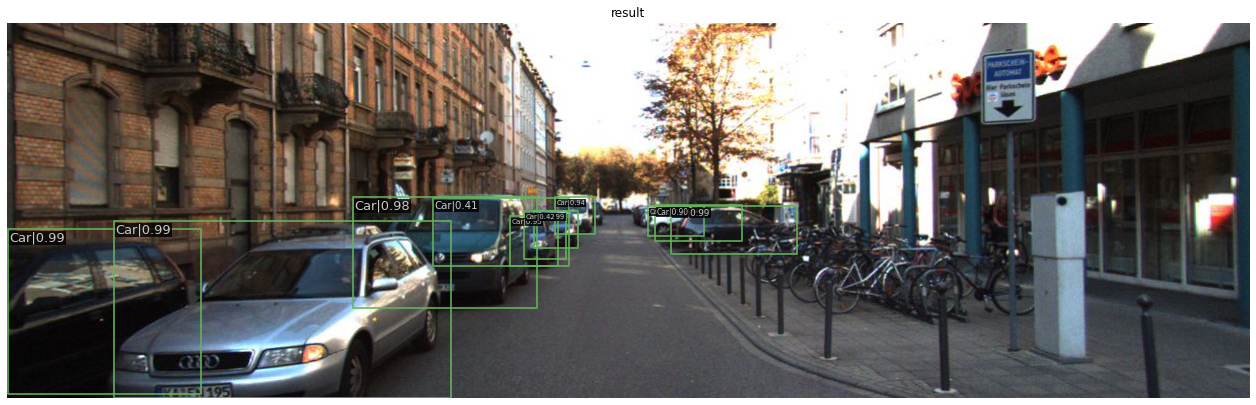

In [32]:
from mmdet.apis import inference_detector, show_result_pyplot

img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)